# What drives user engagement in a music recommendation system?

Music streaming services rely heavily on personalized recommendation systems to keep users engaged and satisfied. These systems help users discover new music, rediscover forgotten tracks, and explore artists that match their taste.

In this project, we explore a real-world music recommendation system pipeline, from data preprocessing to model evaluation. We aim to understand what factors influence recommendation accuracy and user satisfaction, and how we can optimize the recommendation engine accordingly.

## Business Understanding

Music streaming platforms like Spotify and Pandora depend heavily on recommendation systems to retain users, increase engagement, and promote music discovery. A well-optimized recommendation engine improves user satisfaction, reduces churn, and strengthens loyalty to the platform.

This project is a personal effort to explore how these systems are built. By working through the complete pipeline, I aim to understand the challenges faced by data teams in the music technology field. This experience is part of my preparation for entering that industry.

Technically, the project involves evaluating different recommendation strategies and measuring their performance using metrics such as precision, recall, and coverage. The goal is to identify which methods most effectively capture user interest and generate meaningful recommendations.


## Data Understanding

The success of a recommendation system depends on the quality and structure of its data. In this project, we work with user-song interaction data, which includes song IDs, user IDs, and play counts. A separate dataset contains metadata such as song title, artist, release, and year.

Key tasks in this phase include:
- Examining the structure and types of the data
- Identifying missing values or inconsistencies
- Analyzing user activity such as the number of songs each user has listened to
- Analyzing song popularity by counting how many users have listened to each song
- Creating visualizations to detect skewed patterns and sparsity

These steps help us understand the characteristics of the data and guide how we prepare it for modeling.

### **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset: a) the details about the song id, titles, release, artist name, and the year of release (`song_data.csv`), and b) details with the user id, song id, and the play count of users (`count_data.csv`).
- song_data
- song_id - A unique id given to every song
- title - Title of the song
- Release - Name of the released album
- Artist_name - Name of the artist
- year - Year of release
- count_data
- user _id - A unique id given to the user
- song_id - A unique id given to the song
- play_count - Number of times the song was played

**Data Source** - http://millionsongdataset.com/

In [152]:
from sklearn.preprocessing import LabelEncoder # to encode the song & user IDs in this data set
from surprise import accuracy, CoClustering # to compute the accuracy of models, & implementing clustering-based recommendation system
from surprise.reader import Reader # this class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.dataset import Dataset # class for loading datasets
from surprise.model_selection import GridSearchCV, train_test_split, KFold # for splitting the data in train and test dataset
from surprise.prediction_algorithms.knns import KNNBasic # for implementing similarity-based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD # 
from nltk import word_tokenize # word_tokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer # CountVectorizer and TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity # required library to compute the cosine similarity between two vectors
from collections import defaultdict # defaultdict from collections A dictionary output that does not raise a key error

import warnings # used to ignore the warning given as output of the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # regular expression
import nltk # necessary packages to work with text data

warnings.filterwarnings('ignore')
nltk.download('punkt') # Download punkt library
nltk.download('stopwords') # Download stopwords library
nltk.download('wordnet') # Download wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RBIED025\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RBIED025\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RBIED025\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [79]:
# Importing the dataset for song metadata
song_df = pd.read_csv('data/song_data.csv')
display(song_df.shape)
display(song_df.head())

(1000000, 5)

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [80]:
# Importing the dataset with user data
count_df = pd.read_csv('data/count_data.csv')
display(count_df.shape)
display(count_df.head())

(2000000, 4)

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [81]:
# Get the shape of the datasets (rows, columns)
print("Count_df shape:", song_df.shape)
print("Song_df shape:", count_df.shape)

# List all columns and their data types for both song_df & count_df
print("\nColumns and Data Types for Song_df:")
print(song_df.dtypes)

print("\nColumns and Data Types for Count_df:")
print(count_df.dtypes)

Count_df shape: (1000000, 5)
Song_df shape: (2000000, 4)

Columns and Data Types for Song_df:
song_id        object
title          object
release        object
artist_name    object
year            int64
dtype: object

Columns and Data Types for Count_df:
Unnamed: 0     int64
user_id       object
song_id       object
play_count     int64
dtype: object


In [82]:
# Let's check for all sorts of data points on Count_df - Like count of missing values, unique values, and 0s 

# Calculate percent of missing or 0 values for each column
missing_or_zero = count_df.isnull().sum() + (count_df == 0).sum()
percent_missing_or_zero = (missing_or_zero / len(count_df)) * 100

basic_summary = pd.DataFrame({
    'Count of Missing Values': count_df.isnull().sum(),
    'Count of Unique Values': count_df.nunique(),
    'Count of 0s': (count_df == 0).sum(),
    'Count of Duplicates': count_df.duplicated().sum(),
    '% of Missing or 0 Values': percent_missing_or_zero
})
display(basic_summary)

,Count of Missing Values,Count of Unique Values,Count of 0s,Count of Duplicates,% of Missing or 0 Values
Unnamed: 0,0,2000000,1,0,0.00005
user_id,0,76353,0,0,0.00000
song_id,0,10000,0,0,0.00000
play_count,0,295,0,0,0.00000


In [83]:
# Let's check for all sorts of data points on Song_df - Like count of missing values, unique values, and 0s 

# Calculate percent of missing or 0 values for each column
missing_or_zero = song_df.isnull().sum() + (song_df == 0).sum()
percent_missing_or_zero = (missing_or_zero / len(song_df)) * 100

basic_summary = pd.DataFrame({
    'Count of Missing Values': song_df.isnull().sum(),
    'Count of Unique Values': song_df.nunique(),
    'Count of 0s': (song_df == 0).sum(),
    'Count of Duplicates': song_df.duplicated().sum(),
    '% of Missing or 0 Values': percent_missing_or_zero
})
display(basic_summary)

,Count of Missing Values,Count of Unique Values,Count of 0s,Count of Duplicates,% of Missing or 0 Values
song_id,0,999056,0,498,0.0000
title,17,702427,0,498,0.0017
release,7,149287,0,498,0.0007
artist_name,0,72665,0,498,0.0000
year,0,90,484424,498,48.4424


**Leave comment**

In [84]:
# Left merge the count_df and song_df data on "song_id" while also dropping duplicates from song_df
df = pd.merge(count_df, song_df.drop_duplicates(['song_id']), on="song_id", how="left")
# Drop the column 'Unnamed: 0'
df = df.drop ('Unnamed: 0', axis =1)
# Name the obtained dataframe as "df"
df

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


In [85]:
# We will use the label encoding for "user_id" and "song_id", so that they're 
# easy to scan through in this project.
le = LabelEncoder()

df['user_id'] = le.fit_transform(df['user_id'])
df['song_id'] = le.fit_transform(df['song_id'])

df

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,64590,3660,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,3736,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,3744,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,64590,3893,1,Up,My Worlds,Justin Bieber,2010


A dataset of size 2000000 rows x 7 columns can be quite large and will most likely require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate our model efficiently. 

In order to address this issue, it may be necessary to trim down our dataset to a more manageable size.

## Data Preparation

With an initial understanding of the dataset, we move into preparing the data for building recommendation models. This step is crucial, as recommendation systems often suffer from issues like data sparsity and cold starts (i.e., new users or items with little information).

Steps taken in this phase:
- Merged user interaction data with song metadata
- Encoded user and song IDs into numerical form for matrix operations
- Removed users with fewer than 90 song interactions
- Removed songs listened to by fewer than 120 unique users
- Filtered out interactions with play counts greater than 5 to reduce skew

These steps ensure that the remaining data reflects strong and consistent user behavior, which helps improve model training and recommendation quality.

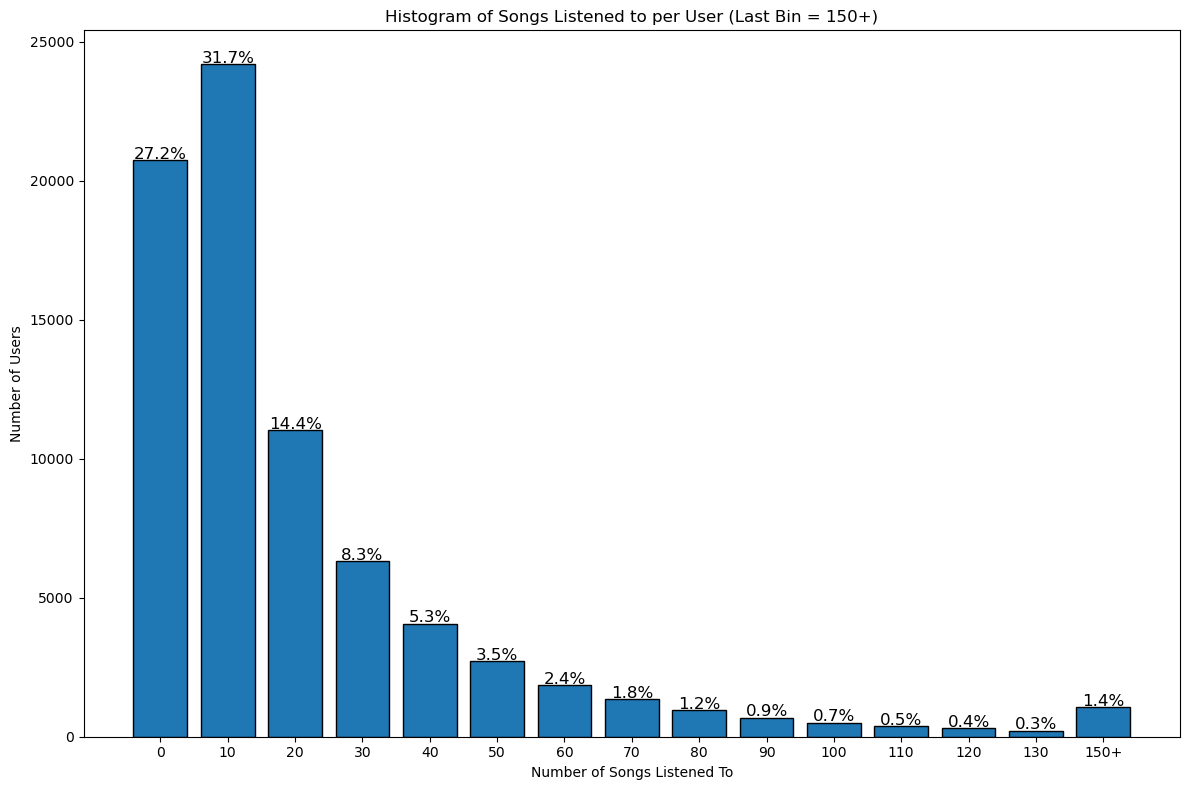

In [86]:
# Count how many songs each user has listened to
user_activity = df.groupby("user_id")["song_id"].count()

# Define bin edges and labels
bins = list(range(0, 150, 10)) + [np.inf]
labels = [f"{i}" for i in range(0, 140, 10)] + ["150+"]

# Bin the data manually
binned = pd.cut(user_activity, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()
percentages = (binned_counts / len(user_activity)) * 100

# Plot
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, binned_counts.values, edgecolor='black')

plt.title("Histogram of Songs Listened to per User (Last Bin = 150+)")
plt.xlabel("Number of Songs Listened To")
plt.ylabel("Number of Users")
plt.ylim(bottom=0)

# Annotate percentage labels centered above each bar
for i, pct in enumerate(percentages):
    plt.text(i, binned_counts[i] + 50, f"{pct:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


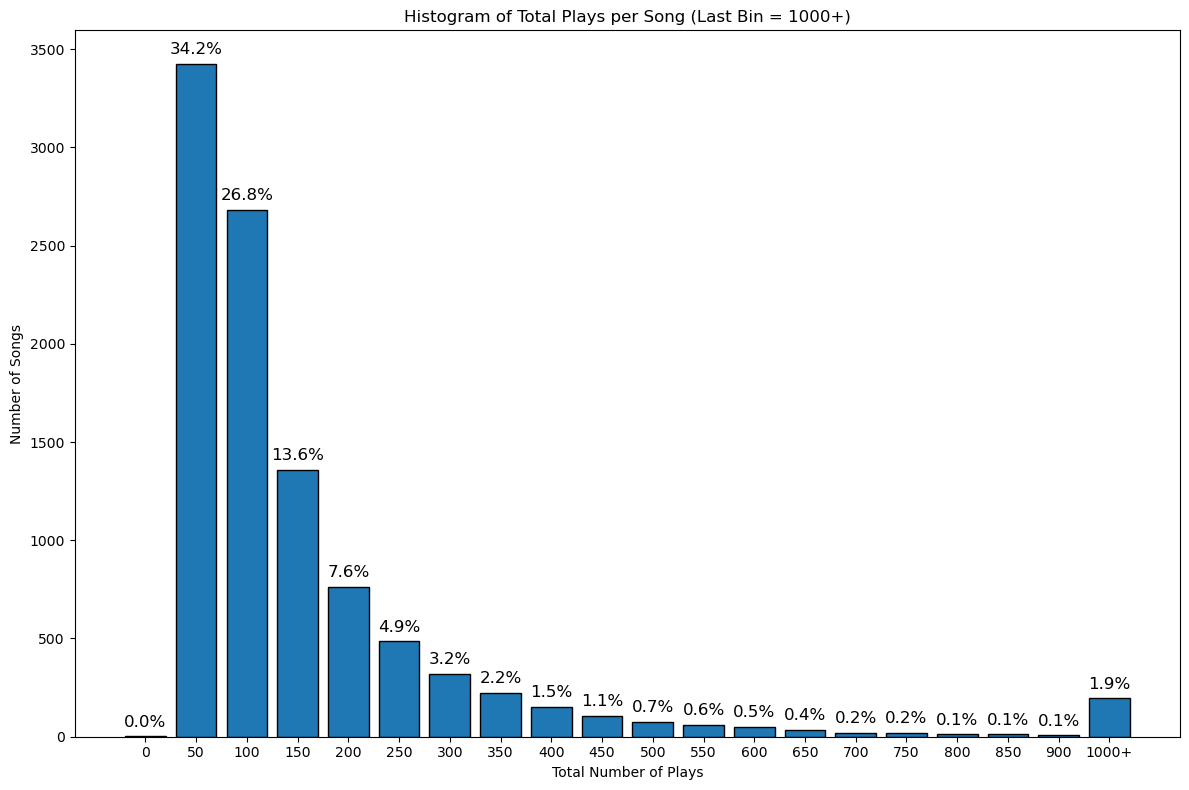

In [87]:
# Count total number of times each song was played
song_play_counts = df.groupby("song_id")["user_id"].count()

# Define bins and labels
bins = list(range(0, 1000, 50)) + [np.inf]
labels = [f"{i}" for i in range(0, 950, 50)] + ["1000+"]

# Bin the data
binned = pd.cut(song_play_counts, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()
percentages = (binned_counts / len(song_play_counts)) * 100

# Plot
plt.figure(figsize=(12, 8))
bars = plt.bar(labels, binned_counts.values, edgecolor='black')

plt.title("Histogram of Total Plays per Song (Last Bin = 1000+)")
plt.xlabel("Total Number of Plays")
plt.ylabel("Number of Songs")
plt.ylim(bottom=0)

# Add percentage labels above each bar
for i, pct in enumerate(percentages):
    plt.text(i, binned_counts[i] + 50, f"{pct:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [88]:
# Filter users who have listened to at least 50 songs
user_counts = df['user_id'].value_counts()
active_users = user_counts[user_counts >= 60].index
df = df[df['user_id'].isin(active_users)]

# Filter songs that have been listened to by at least 120 users
song_user_counts = df.groupby('song_id')['user_id'].nunique()
popular_songs = song_user_counts[song_user_counts >= 150].index
df_final = df[df['song_id'].isin(popular_songs)]

# Drop records where play_count > 20, so we filter out the users that absolutely binged specific songs
df_final = df_final[df_final['play_count'] <= 10]

# Check the shape of the filtered data
print("Filtered dataset shape:", df_final.shape)

Filtered dataset shape: (255082, 7)


In [89]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset but take only "user_id","song_id", and "play_count"
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

# Confirm shapes
print("Trainset size:", trainset.n_ratings) # trainset.n_ratings gives us the number of observations used in training
print("Testset size:", len(testset)) # testset is just a list of (user, item, rating) tuples, so we have to use len()

Trainset size: 204065
Testset size: 51017


### Applied Filters

The following rules were applied to clean the dataset:

- Removed **users who listened to fewer than 60 songs**.
- Removed **songs that were listened to by fewer than 150 unique users** 
- Dropped **user-song interactions** where `play_count > 10` to reduce my models' over sensitivity from repeated plays

## Modeling

With our data prepped, we now turn to building recommendation models. There are several classes of algorithms available for this task, each with its own strengths and weaknesses.

Approaches explored in this section:
- **Popularity-Based Filtering**: recommends songs with the highest overall play counts
- **Collaborative Filtering**: includes User-User similarity, Item-Item similarity, Matrix Factorization (SVD), and Co-Clustering
- **Content-Based Filtering**: uses song metadata such as artist, release, or year to recommend similar tracks

Each model is evaluated using a test set and key performance metrics. We also apply parameter tuning where appropriate to improve results.

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [90]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column
avg_plays = df_final.groupby('song_id')['play_count'].mean()
# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column
song_freq = df_final.groupby('song_id')['play_count'].count()

In [91]:
# Making a dataframe with the average_count and play_freq
final_plays = pd.DataFrame({'Average Plays': avg_plays, 'Play Frequency': song_freq})
# Let us see the first five records of the final_play dataset
final_plays.head()

,Average Plays,Play Frequency
song_id,,
16,2.155172,174
21,1.850356,421
22,1.484536,194
50,2.134078,179
52,2.115962,733


In [92]:
# Build the function to find top n songs
def top_n_songs(final_plays, n, min_plays):

    recommendations = final_plays.loc[final_plays['Play Frequency'] > min_plays]

    recommendations = recommendations.sort_values(by='Average Plays', ascending = False)

    return pd.DataFrame({'song_id': recommendations.index[:n]}).reset_index(drop=True)

In [93]:
# Recommend top 10 songs using the function defined above
top_n_songs(final_plays, 10, 50)

,song_id
0,7224
1,6450
2,9942
3,8324
4,6860
5,614
6,317
7,657
8,5653
9,8483


### **User-User Similarity-Based (Collaborative Filtering)**

User-user collaborative filtering recommends items to a user based on the preferences of similar users. It works by finding users with similar interaction patterns and recommending songs they liked but the target user hasn't listened to yet.

In this implementation, we use **KNNBasic** from the `surprise` library with **cosine similarity** and **user-based similarity enabled**.

Key setup details:
- Similarity metric: **Cosine** (with user-based similarity enabled)
- Training algorithm: **KNNBasic**
- Recommendation strategy: **Top-N items from similar users**

In [94]:
# Building a default user-user-similarity model
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options= sim_options, verbose= False, random_state= 1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

In [95]:
# This function is made so that I could randomly select a `song_id` from a randomly selected `user_id` and
# be given that song's `play_count` because I found myself having to run the entire df_final to choose a
# random `user_id` and random `song_id`, which I found to be inefficient. So then why not make a code do it
# for me so that I don't have to throughout the process of making this project.

import random

def random_play_count(user_id=None, df=df_final) -> None:
    if user_id is None:
        # Select a random user_id
        random_user_id = random.choice(df['user_id'].unique())
    else:
        random_user_id = user_id

    # Filter DataFrame to rows with the chosen user_id
    user_rows = df[df['user_id'] == random_user_id]

    # Select a random song_id not in the user's rows
    unique_song_ids = df['song_id'].unique()
    user_song_ids = user_rows['song_id'].unique()
    remaining_song_ids = np.setdiff1d(unique_song_ids, user_song_ids)
    random_song_id = random.choice(remaining_song_ids)

    # Get a random play_count for the selected song_id
    play_count = random.choice(df[df['song_id'] == random_song_id]['play_count'].values)

    # Print the result
    print(f'For user_id: {random_user_id}, song_id: {random_song_id}, play_count is: {play_count}')

random_play_count()

For user_id: 21258, song_id: 7321, play_count is: 6


In [96]:
# Predicting play_count for a sample user with a listened song
# Use any user id  and song_id
sim_user_user.predict(21258, 7321, verbose = True)

user: 21258      item: 7321       r_ui = None   est = 1.70   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=21258, iid=7321, r_ui=None, est=1.7, details={'actual_k': 40, 'was_impossible': False})

In [97]:
# This is to find a random song_id that the user_id from the function I made did NOT listen to, so that making
# this project felt more efficient.

def random_id(df=df_final, user_id=None, song_id=None) -> None:
    if user_id is not None:
        # Filter DataFrame to rows without the chosen user_id
        song_rows = df[df['user_id'] == user_id]

        # Select a random song_id from the filtered DataFrame
        random_song_id = random.choice(song_rows['song_id'].unique())

        # Print the result
        print(f"For user_id: {user_id}, an unheard random song_id is: {random_song_id}")
    else:
        # Select a random user_id
        random_user_id = random.choice(df['user_id'].unique())

        if song_id is not None:
            # Filter DataFrame to rows without the chosen song_id
            user_rows = df[df['song_id'] != song_id]

            # Select a random user_id from the filtered DataFrame
            random_user_id = random.choice(user_rows['user_id'].unique())

        # Filter DataFrame to rows with the chosen user_id
        song_rows = df[df['user_id'] == random_user_id]

        # Select a random song_id from the filtered DataFrame
        random_song_id = random.choice(song_rows['song_id'].unique())

        # Print the result
        print(f"For song_id: {song_id}, a user_id that hasn't heard this is: {random_user_id}")

random_id(user_id=21258)

For user_id: 21258, an unheard random song_id is: 7422


In [98]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict(21258, 7422, verbose = True)

user: 21258      item: 7422       r_ui = None   est = 1.45   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=21258, iid=7422, r_ui=None, est=1.45, details={'actual_k': 40, 'was_impossible': False})

In [100]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [40, 50, 60], 'min_k': [6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
 # Use entire data for GridSearch
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.7685210978291754
{'k': 60, 'min_k': 12, 'sim_options': {'name': 'msd', 'user_based': True}}


In [101]:
# Train the best model found in above gridsearch
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 60, min_k = 12, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

In [102]:
# This function is made so that I could get the top n recommendations for the specified user_id,
# based on the type of similarity-based (user-user & item-item) recommendation model we specify
# and created within the notebook.

def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'song_id', values = 'play_count')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for song_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, song_id).est

        # Appending the predicted ratings
        recommendations.append((song_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user


In [103]:
random_play_count()

For user_id: 59541, song_id: 5095, play_count is: 5


In [104]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 59541, 5, sim_user_user_optimized)

# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_count'])

,song_id,predicted_play_count
0,7224,4.097330
1,9942,4.000000
2,8324,3.834369
3,5531,3.683333
4,6450,3.549755


In [105]:
def ranking_songs(recommendations, final_plays):
  # Sort the songs based on play counts
  ranked_products = final_plays.loc[[items[0] for items in recommendations]].sort_values('Play Frequency', ascending = False)[['Play Frequency']].reset_index()

  # Merge with the recommended songs to get predicted play_count
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_count']), on = 'song_id', how = 'inner')

  # Rank the songs based on corrected play_counts
  ranked_products['corrected_ratings'] = ranked_products['predicted_play_count'] - 1 / np.sqrt(ranked_products['Play Frequency'])

  # Sort the songs based on corrected play_counts
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)

  return ranked_products

In [106]:
# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
3,7224,206,4.097330,4.027656
1,9942,333,4.000000,3.945200
4,8324,192,3.834369,3.762200
0,5531,1405,3.683333,3.656655
2,6450,245,3.549755,3.485868


Wow that was a really close set of predictions using our optimized User-User model!

Let's try the next similarity-based model.

### **Item-Item Similarity-Based (Collaborative Filtering)**

Item-item collaborative filtering recommends songs to a user based on how similar songs are to those they’ve already listened to. Instead of comparing users, this approach compares songs based on who has listened to them and how often.

Key setup details:
- Similarity metric: **Cosine** (with item-based similarity enabled)
- Training algorithm: **KNNBasic**
- Recommendation strategy: **Top-N similar items to those the user has interacted with**

In [108]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

In [109]:
random_play_count()

For user_id: 55382, song_id: 5943, play_count is: 1


In [110]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 55382, 5, sim_item_item)

# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
2,8163,156,2.955977,2.875913
4,7505,149,2.920588,2.838665
1,4598,159,2.899516,2.820211
0,7586,169,2.841111,2.764188
3,7782,151,2.825948,2.744569


In [111]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [40, 50, 60], 'min_k': [6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.7079852074095883
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [112]:
# Optimized item-item
sim_item_item_optimized = KNNBasic(sim_options={'name': 'cosine', 'user_based': False},
                                   k=40, min_k=6, random_state=1)
sim_item_item_optimized.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### **User-Item Interaction-Based (Collaborative Filtering)**

User-item interaction-based filtering uses a matrix of users and items to identify latent patterns. Models like **Singular Value Decomposition (SVD)** or matrix factorization break this matrix down into lower-dimensional representations, capturing underlying preferences and similarities. So, we'll be treating user-song play counts as implicit ratings and use them to predict unknown preferences.

Key setup details:
- Similarity metric: **Latent factors via matrix decomposition**
- Training algorithm: **Singular Value Decomposition (SVD)**
- Recommendation strategy: **Predict missing ratings by modeling hidden user and item preferences in a latent space**

In [113]:
# Build baseline model using svd
svd = SVD(random_state = 1)

# Training the algorithm on the train set
svd.fit(trainset)

In [114]:
random_play_count()

For user_id: 61613, song_id: 357, play_count is: 1


In [116]:
svd.predict(61613, 357, verbose = True)

user: 61613      item: 357        r_ui = None   est = 1.29   {'was_impossible': False}


Prediction(uid=61613, iid=357, r_ui=None, est=1.2904951026135727, details={'was_impossible': False})

In [115]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 61613, 5, svd)

# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
3,7224,206,3.885470,3.815796
2,5653,229,3.818202,3.752120
1,4864,417,3.722065,3.673094
0,6246,881,3.680806,3.647115
4,8324,192,3.619297,3.547128


In [118]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40, 50, 60], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Step 3: Print best results
print(gs_svd.best_score['rmse'])
print(gs_svd.best_params['rmse'])

1.629081218002713
{'n_epochs': 60, 'lr_all': 0.005, 'reg_all': 0.2}


In [119]:
# Step 4: Train optimized SVD model
svd_optimized = SVD(n_epochs=60, lr_all=0.005, reg_all=0.2)
svd_optimized.fit(trainset)

In [120]:
random_play_count()

For user_id: 55724, song_id: 8256, play_count is: 1


In [121]:
svd_optimized.predict(55724, 8256, verbose = True)

user: 55724      item: 8256       r_ui = None   est = 1.50   {'was_impossible': False}


Prediction(uid=55724, iid=8256, r_ui=None, est=1.5038196691770482, details={'was_impossible': False})

In [128]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 55724, 5, svd_optimized)

# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
1,1664,967,3.249684,3.217526
0,317,1090,3.245009,3.214720
4,7224,206,3.206585,3.136912
2,6246,881,3.074779,3.041089
3,6860,390,3.051806,3.001169


### **Co-Clustering-Based (Filtering Technique sometimes utilized for Hybrid Systems)**

Co-clustering is a collaborative filtering approach that simultaneously clusters users and items into groups and learns preferences between these groups. It can be seen as a hybrid of collaborative and unsupervised learning, offering more stability in sparse datasets. This method identifies patterns between **user clusters** and **item clusters**, which can enhance generalization and reduce overfitting.

Key setup details:
- Similarity metric: **None explicitly used** (clustering-based, not distance-based)
- Training algorithm: **CoClustering**
- Recommendation strategy: **Predict ratings based on interactions between user and item clusters**

In [123]:
# Make baseline clustering model
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

In [126]:
random_play_count()

For user_id: 53169, song_id: 7628, play_count is: 2


In [127]:
clust_baseline.predict(53169, 7628, verbose = True)

user: 53169      item: 7628       r_ui = None   est = 1.50   {'was_impossible': False}


Prediction(uid=53169, iid=7628, r_ui=None, est=1.4973316442260716, details={'was_impossible': False})

In [129]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 53169, 5, clust_baseline)

# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
3,7224,206,3.651897,3.582224
2,6450,245,3.265076,3.201189
4,8324,192,3.060792,2.988623
1,9942,333,2.965975,2.911176
0,6860,390,2.786077,2.735440


In [124]:
# Step 1: Define parameter grid for CoClustering
param_grid = {
    'n_cltr_u': [3, 4, 5, 6],
    'n_cltr_i': [3, 4, 5, 6],
    'n_epochs': [30, 40, 50, 60, 70, 80, 90]
}

# Step 2: Grid Search
gs_co = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs_co.fit(data)

# Step 3: Print best results
print(gs_co.best_score['rmse'])
print(gs_co.best_params['rmse'])

1.71221098911525
{'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 70}


In [125]:
# Step 4: Train optimized CoClustering model
clust_tuned = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=70, random_state=1)
clust_tuned.fit(trainset)

In [131]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 53169, 5, clust_tuned)

# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_plays)

,song_id,Play Frequency,predicted_play_count,corrected_ratings
3,7224,206,3.651897,3.582224
2,6450,245,3.265076,3.201189
4,8324,192,3.060792,2.988623
1,9942,333,2.965975,2.911176
0,6860,390,2.786077,2.735440


### **Content-Based Filtering**

Content-based filtering recommends songs to a user by comparing item features (like genre, artist, or year), to items the user has already liked. It assumes that users will prefer items similar to their past preferences and apply content-based filtering using metadata from the `song_data` table (e.g., artist, release, year), comparing feature vectors across items.

Key setup details:
- Similarity metric: **Cosine similarity** (based on song metadata vectors)
- Training algorithm: **Manual feature engineering or content-similarity scoring** (no model fitting required)
- Recommendation strategy: **Recommend songs with metadata profiles similar to those the user has already liked**

In [132]:
# Just setting up another df to be reduced
df_small = df_final

# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title']+ ' ' + df_small['release']+ ' ' + df_small['artist_name']

df_small

,user_id,song_id,play_count,title,release,artist_name,year,text
130,54498,97,3,Harder Better Faster Stronger,Discovery,Daft Punk,2007,Harder Better Faster Stronger Discovery Daft Punk
132,54498,299,3,Aerodynamic,Discovery,Daft Punk,2001,Aerodynamic Discovery Daft Punk
140,54498,1364,2,Face To Face,Discovery,Daft Punk,2001,Face To Face Discovery Daft Punk
141,54498,1911,3,Digital Love,Ministry of Sound Presents Chilled II 1991-2009,Daft Punk,2001,Digital Love Ministry of Sound Presents Chille...
150,54498,3356,2,Around The World (Radio Edit),Musique Vol 1,Daft Punk,1996,Around The World (Radio Edit) Musique Vol 1 Da...
...,...,...,...,...,...,...,...,...
1999736,47786,9186,1,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,1997,Bitter Sweet Symphony Bitter Sweet Symphony Th...
1999745,47786,9351,2,The Police And The Private,Live It Out,Metric,2005,The Police And The Private Live It Out Metric
1999746,47786,9365,2,Joy Ride,Day & Age,The Killers,2008,Joy Ride Day & Age The Killers
1999755,47786,9543,1,Just Friends,Back To Black,Amy Winehouse,2006,Just Friends Back To Black Amy Winehouse


In [133]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]
# Drop the duplicates from the title column
df_small.drop_duplicates(['title'], inplace = True)
# Set the title column as the index
df_small = df_small.set_index('title')
# See the first 5 records of the df_small dataset
df_small

,user_id,song_id,play_count,text
title,,,,
Harder Better Faster Stronger,54498,97,3,Harder Better Faster Stronger Discovery Daft Punk
Aerodynamic,54498,299,3,Aerodynamic Discovery Daft Punk
Face To Face,54498,1364,2,Face To Face Discovery Daft Punk
Digital Love,54498,1911,3,Digital Love Ministry of Sound Presents Chille...
Around The World (Radio Edit),54498,3356,2,Around The World (Radio Edit) Musique Vol 1 Da...
...,...,...,...,...
Tuesday Moon,40273,2786,1,Tuesday Moon Everything Is Neutral Milk Hotel
Miss Independent,72757,6590,1,Miss Independent Thankful Kelly Clarkson
Starlight,64015,3466,1,Starlight Starlight Muse


In [134]:
# Create a function to tokenize the text
def tokenize(text):

    # Making each letter as lowercase and removing non-alphabetical text
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    # Extracting each word in the text
    tokens = word_tokenize(text)

    # Removing stopwords
    words = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize the words
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [138]:
# Create tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenize)

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array
songs_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

In [141]:
# Compute the cosine similarity for the tfidf above output
similar_songs = cosine_similarity(songs_tfidf, songs_tfidf)

 Finally, let's create a function to find most similar songs to recommend for a given song.

In [145]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)

In [146]:
# This little function will leverage the model we just made based off the Content-based filtering model we just trained,
# and recommend others based solely on those tokenized lyrics

def recommendations(title, similar_songs):

    recommended_songs = []

    # Getting the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # Getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1 : 11].index)
    print(top_10_indexes)

    # Populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])

    return recommended_songs

In [147]:
# Recommending 10 songs similar to one of my all-time favorite songs, called "Learn to Fly" by Foo Fighters!

recommendations('Learn To Fly', similar_songs)

[629, 381, 338, 654, 513, 595, 589, 590, 570, 571]


['Big Me',
 'Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Slow Dancing In A Burning Room',
 'Perfectly Lonely',
 'Bad Moon Rising',
 'One Minute To Midnight']

I can confirm that these songs are in fact awesome recommendations, and a part of my already-made playlists on Spotify.

## Evaluation

After training our models, we evaluate their performance to understand how well they recommend music to users. We use metrics common to recommendation systems, such as:

- **RMSE**: Measures the accuracy of predicted ratings. Lower values indicate better predictions.
- **Precision@k**: The proportion of recommended items in the top-k that are relevant.
- **Recall@k**: The proportion of relevant items that appear in the top-k recommendations.
- **F1 Score**: The harmonic mean of precision and recall, useful for balancing both metrics.

These metrics help us compare models not just on accuracy, but also on user experience factors like variety and personalization. Evaluation results are interpreted in the context of business needs, whether we’re optimizing for engagement, discovery, or satisfaction.

### Evaluation Toolset

 The functions below are made so that we could assess what the precision, recall, and F1 score are at defined k metrics
 for each user. The reason why I chose to use these metrics is due to their alignment with the overall goal of
 recommendation systems - to provide a variety of song recommendations while also remaining personalized.

In [148]:
# I've used this type of methodology in the past, and figured if we had a organized way to measure the output of our models,
# that it would drastically help in reducing clutter for this project's jupyter notebook.

def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""
    
    user_est_true = defaultdict(list)
    predictions=model.test(testset)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True) 
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings) 

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k]) 

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) 
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0 

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    accuracy.rmse(predictions)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

In [149]:
# This function is almost identical to the precision_recall_at_k() up above, but instead runs different values
# of thresholds from 1 up to 1.75 in increments of 0.15 so that we could compare the metrics at different thresholds.

def precision_recall_at_k_table(model, k=30, threshold_list=None):
    if threshold_list is None:
        threshold_list = [1 + 0.15 * i for i in range(6)]

    results = []

    for threshold in threshold_list:
        user_est_true = defaultdict(list)
        predictions = model.test(testset)

        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
        recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
        rmse = accuracy.rmse(predictions, verbose=False)
        f1_score = round((2 * precision * recall) / (precision + recall), 3)

        results.append([rmse, precision, recall, f1_score])

    results_df = pd.DataFrame(results, columns=['RMSE', 'Precision', 'Recall', 'F1 Score'], index=threshold_list)
    results_df.index.name = 'Threshold'

    return results_df

In [150]:
def model_metrics_table(models, k=30, threshold_list=None):
    if threshold_list is None:
        threshold_list = [1 + 0.15 * i for i in range(6)]

    results = []

    for model_name, model in models.items():
        for threshold in threshold_list:
            user_est_true = defaultdict(list)
            predictions = model.test(testset)

            for uid, _, true_r, est, _ in predictions:
                user_est_true[uid].append((est, true_r))

            precisions = dict()
            recalls = dict()
            for uid, user_ratings in user_est_true.items():
                user_ratings.sort(key=lambda x: x[0], reverse=True)

                n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
                n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
                n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                      for (est, true_r) in user_ratings[:k])

                precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
                recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

            precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
            recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
            rmse = accuracy.rmse(predictions, verbose=False)
            f1_score = round((2 * precision * recall) / (precision + recall), 3)

            results.append([model_name, threshold, rmse, precision, recall, f1_score])

    results_df = pd.DataFrame(results, columns=['Model', 'Threshold', 'RMSE', 'Precision', 'Recall', 'F1 Score'])
    results_df = results_df.set_index(['Model', 'Threshold'])

    return results_df

### Actual Evaluation

In [155]:
# The purpose behind this defined table above is so that we could have an organized table
# that puts together all the metric scores from the 4 different recommendation models
# that allow us to score them appropriately, not counting the content-based model. The other
# reason is to make their evaluation in the summary below to be simpler to follow and require
# much less effort to do it. Throughout this project, I hadn't placed all the metrics this easily visbile
# above the summary and after going back and fourth writting the summary I manually placed them in
# the end, but what's the point of doing a full-code evaluation if im not going to code a nicely
# organized table aswell?

models = {
    'User-User': sim_user_user, 
    'User-User Tuned': sim_user_user_optimized, 
    'Item-Item': sim_item_item, 
    'Item-Item Tuned': sim_item_item_optimized, 
    'SVD': svd, 
    'SVD Tuned': svd_optimized, 
    'Co-Clustered': clust_baseline,
    'Co-Clustered Tuned': clust_tuned
}

model_metrics_table(models)

RMSE  Precision  Recall  F1 Score
Model              Threshold                                       
User-User          1.00       1.825828      1.000   0.998     0.999
                   1.15       1.825828      0.417   0.828     0.555
                   1.30       1.825828      0.419   0.804     0.551
                   1.45       1.825828      0.422   0.767     0.544
                   1.60       1.825828      0.423   0.715     0.532
                   1.75       1.825828      0.421   0.639     0.508
User-User Tuned    1.00       1.815915      1.000   0.998     0.999
                   1.15       1.815915      0.417   0.832     0.556
                   1.30       1.815915      0.419   0.813     0.553
                   1.45       1.815915      0.422   0.777     0.547
                   1.60       1.815915      0.426   0.729     0.538
                   1.75       1.815915      0.426   0.659     0.517
Item-Item          1.00       1.696300      1.000   0.998     0.999
                   1.15       1.696300      0.408   0.799     0.540
                   1.30       1.696300      0.393   0.737     0.513
                   1.45       1.696300      0.375   0.670     0.481
                   1.60       1.696300      0.351   0.595     0.442
                   1.75       1.696300      0.328   0.523     0.403
Item-Item Tuned    1.00       1.696700      1.000   0.998     0.999
                   1.15       1.696700      0.410   0.802     0.543
                   1.30       1.696700      0.397   0.742     0.517
                   1.45       1.696700      0.380   0.677     0.487
                   1.60       1.696700      0.356   0.603     0.448
                   1.75       1.696700      0.334   0.532     0.410
SVD                1.00       1.684418      0.997   0.939     0.967
                   1.15       1.684418      0.424   0.772     0.547
                   1.30       1.684418      0.430   0.732     0.542
                   1.45       1.684418      0.433   0.681     0.529
                   1.60       1.684418      0.434   0.625     0.512
                   1.75       1.684418      0.435   0.568     0.493
SVD Tuned          1.00       1.617039      1.000   0.991     0.995
                   1.15       1.617039      0.420   0.821     0.556
                   1.30       1.617039      0.426   0.790     0.554
                   1.45       1.617039      0.433   0.733     0.544
                   1.60       1.617039      0.433   0.658     0.522
                   1.75       1.617039      0.427   0.582     0.493
Co-Clustered       1.00       1.698059      0.981   0.886     0.931
                   1.15       1.698059      0.424   0.747     0.541
                   1.30       1.698059      0.424   0.707     0.530
                   1.45       1.698059      0.418   0.658     0.511
                   1.60       1.698059      0.413   0.609     0.492
                   1.75       1.698059      0.403   0.558     0.468
Co-Clustered Tuned 1.00       1.698059      0.981   0.886     0.931
                   1.15       1.698059      0.424   0.747     0.541
                   1.30       1.698059      0.424   0.707     0.530
                   1.45       1.698059      0.418   0.658     0.511
                   1.60       1.698059      0.413   0.609     0.492
                   1.75       1.698059      0.403   0.558     0.468

### Tuning Effects by Model

**User-User Collaborative Filtering**
- **Tuning Impact**: Slight improvement in RMSE (1.826 to 1.816), with marginal gains in precision and recall across thresholds.
- **Interpretation**: Results were nearly identical before and after tuning. Since users may not share many listening patterns, especially after filtering out low-activity users, user-user similarity has a limited neighborhood to learn from.
- **Potential improvements**:
    - Explore alternative similarity metrics, like MSD or Pearson
    - Use a denser dataset or apply dimensionality reduction before similarity computation
    - Consider blending User-User signals with Item-based scores in a hybrid model

**Item-Item Collaborative Filtering**
- **Tuning Impact**: RMSE remained essentially unchanged (1.696), with modest increases in precision and recall at most thresholds.
- **Interpretation**: Tuning had a small positive effect, but the model may already be operating near its optimal range for this dataset. Songs typically have more consistent patterns across many users, so even without heavy tuning the model seems to capture core popularity-driven relationships
- **Potential improvements**:
    - Include item metadata to build a hybrid content-collaborative model
    - Try normalizing play counts before model input to smooth interaction intensity
    - Experiment with tighter pruning thresholds for long-tail songs

**SVD (Matrix Factorization)**
- **Tuning Impact**: This model showed the most substantial improvement across all metrics. RMSE decreased significantly (1.684 to 1.617), and both precision and recall consistently improved.
- **Interpretation**: SVD is highly responsive to parameter tuning and benefits from modeling latent features. It demonstrated the strongest performance gains overall.
- **Potential improvements**:
    - Use more advanced matrix factorization models (e.g., SVD++)
    - Perform more exhaustive grid search (maybe? not sure how much that would've helped vs other models as mentioned)

**Co-Clustering**
- **Tuning Impact**: No observable improvement. The baseline and tuned models produced identical metric values.
- **Interpretation**: This may indicate that Co-Clustering was insensitive to the tuned parameters or that its assumptions are not well-suited for this dataset.
- **Potential improvements**:
    - Try initializing clusters using metadata (e.g., artist genre or release decade)
    - Use this technique only in hybrid systems where clusters augment another model’s predictions


In [157]:
results_df = model_metrics_table(models)

# We're going to filter for the results from the threshold 1.15 and only tuned models
# Looking into a lower threshold like 1.15 means we were looking at how well the models did when considering a 
# larger number of songs to be "relevant" for each user. If we had used a higher threshold, 
# we would have been looking at how well the models did when considering a smaller number of songs to be "relevant."

tuned_models = ['User-User Tuned', 'Item-Item Tuned', 'SVD Tuned', 'Co-Clustered Tuned']
metrics_df = results_df.loc[(slice(None), 1.15), :].reset_index()
metrics_df = metrics_df[metrics_df['Model'].isin(tuned_models)]
metrics_df = metrics_df.set_index('Model')[['Precision', 'Recall', 'F1 Score']]

print(metrics_df)

                    Precision  Recall  F1 Score
Model                                          
User-User Tuned         0.417   0.832     0.556
Item-Item Tuned         0.410   0.802     0.543
SVD Tuned               0.420   0.821     0.556
Co-Clustered Tuned      0.424   0.747     0.541


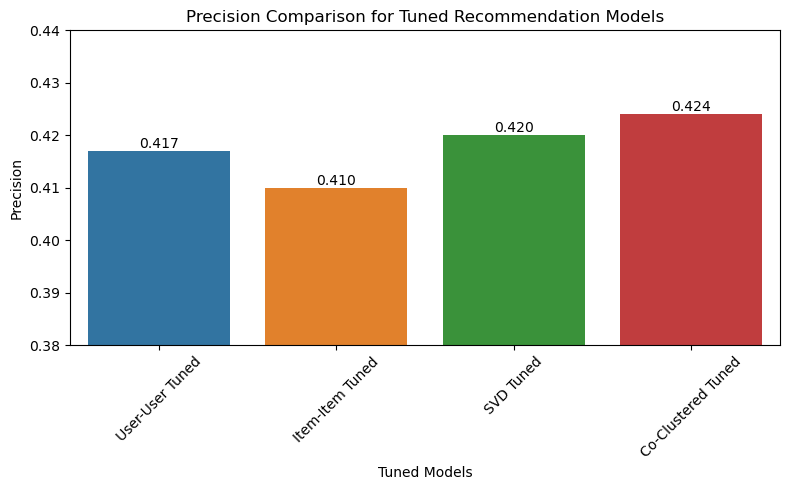

In [169]:
# Plot Precision with data labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=metrics_df.index, y='Precision', data=metrics_df)
plt.title('Precision Comparison for Tuned Recommendation Models')
plt.ylabel('Precision')
plt.xlabel('Tuned Models')
plt.ylim(0.38, 0.44)
plt.xticks(rotation=45)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

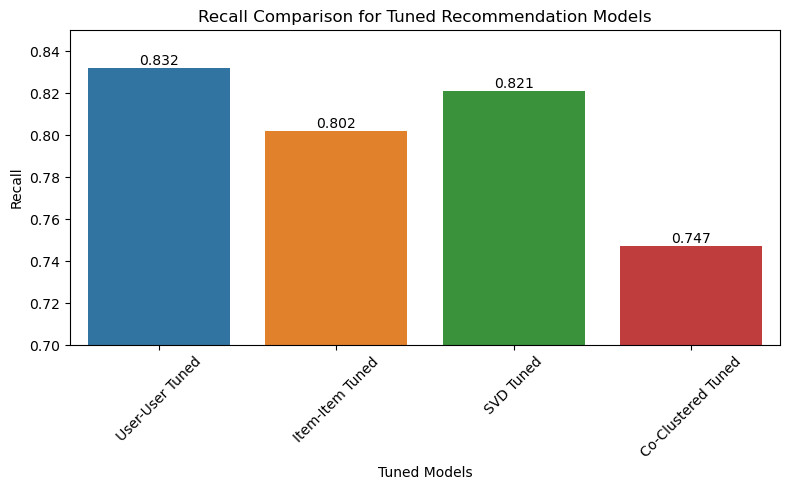

In [164]:
# Plot Recall with data labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=metrics_df.index, y='Recall', data=metrics_df)
plt.title('Recall Comparison for Tuned Recommendation Models')
plt.ylabel('Recall')
plt.xlabel('Tuned Models')
plt.ylim(0.7, 0.85)
plt.xticks(rotation=45)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

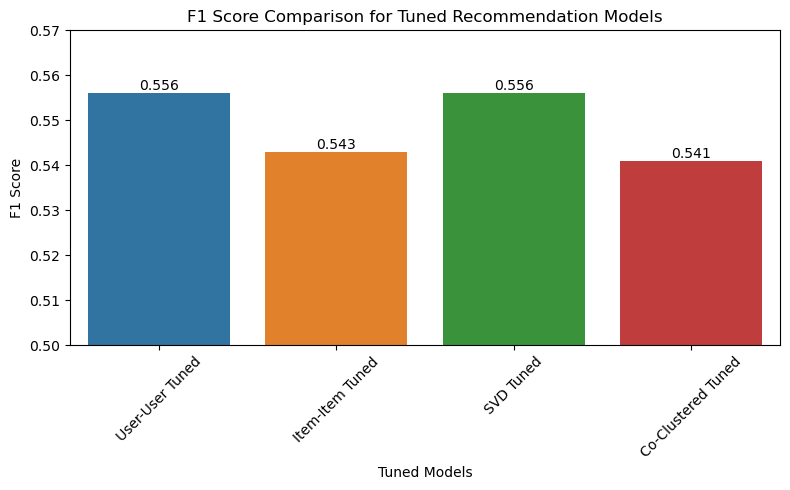

In [165]:
# Plot F1 Score with data labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=metrics_df.index, y='F1 Score', data=metrics_df)
plt.title('F1 Score Comparison for Tuned Recommendation Models')
plt.ylabel('F1 Score')
plt.xlabel('Tuned Models')
plt.ylim(0.5, 0.57)
plt.xticks(rotation=45)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Deployment and Final Recommendation Strategy

This project gave me the opportunity to simulate the development and evaluation of a music recommendation system from start to finish. My main goal was to understand how different modeling decisions affect the user experience, particularly in terms of relevance, variety, and recommendation quality.

Although I didn’t deploy a live system, I structured the process the way a real production pipeline might be handled. If this were deployed, next steps would include packaging the best-performing model as an API, logging user interactions to refine recommendations, and using A/B testing to validate performance improvements. This exercise gave me a hands-on look at the kinds of decisions data teams make when building scalable recommendation systems.

One of the biggest takeaways for me was realizing how sensitive recommender systems can be-not just to tuning, but to the structure and cleanliness of the data itself. The entire pipeline matters.

## Performance Comparison Across Models

I tested four types of recommendation models: User-User, Item-Item, SVD (matrix factorization), and Co-Clustering. Each was evaluated both before and after tuning using RMSE, Precision@k, Recall@k, and F1 Score.

Tuning had very different effects depending on the model. User-User and Item-Item models showed small but consistent improvements in F1 Score after tuning. Co-Clustering didn’t improve at all, with its pre- and post-tuning results being identical. On the other hand, the SVD model showed clear improvements across every metric. After tuning, it achieved the lowest RMSE (1.617) and the highest F1 Score (0.556 at threshold 1.15), making it the most balanced model overall.

This wasn’t surprising. SVD is known for being sensitive to parameter tuning and excels at capturing complex patterns in the data. Neighborhood-based models like User-User and Item-Item often reach their limits quickly, especially in sparse datasets like this one. Co-Clustering was stable but didn’t respond to tuning, which may be a sign that it’s better suited for hybrid use cases or larger datasets with clearer group structure.

## Evaluation Strategy and Metric Selection

In this project, I focused on using Precision@k as the primary metric. In a real music app, users rarely scroll past the first few recommendations, so making sure those first items are relevant is crucial. But I also looked at Recall@k and F1 Score to ensure the models weren’t overfitting to popularity or being too conservative.

F1 Score was particularly helpful. It gave me a balanced view that captured both the accuracy of individual recommendations and the model’s ability to recover a variety of relevant songs. What I noticed is that while several models achieved perfect or near-perfect precision at the lowest threshold (1.00), their recall dropped quickly as the threshold increased. That told me that precision alone isn’t enough ... we need recall to maintain diversity and usefulness over time.

## Reflections on Design and Scaling

Because of computational limits, I had to reduce the original dataset from over 2 million rows down to just about 250k. I filtered out users who had interacted with fewer than 60 songs and songs that hadn’t been heard by at least 150 unique users. This was necessary to avoid extreme sparsity and make the training process more manageable.

If I had access to more computational resources, I would have explored training on a larger sample, possibly using more granular feedback like skip counts or playlist additions. In a production setting, the data pipeline would likely include richer behavioral data and be updated in real-time. This experience made me appreciate how much of a recommender’s success comes down to the infrastructure behind it, not just the model itself.

It also made me wonder what kind of engineering effort goes into collecting and storing interaction data at the scale of millions of users. I’ve seen that companies like Spotify let users request a full export of their data. That alone suggests they’ve built robust data systems and privacy-compliant pipelines capable of handling these kinds of requests. Maintaining and monitoring those systems would likely require a dedicated team.

## Final Recommendation

Based on all the metrics I evaluated, I would recommend deploying the **SVD Tuned** model. It consistently outperformed the others in terms of RMSE, precision, and recall, and had the highest F1 Score overall. This model was able to generalize across sparse interactions and adapt well to parameter tuning, which made it a strong candidate for real-world use.

That said, I also learned that no model is perfect. Even the best-performing model is only as good as the data it’s trained on and the context it’s deployed in. In future iterations, I would consider blending models into a hybrid system or incorporating additional feedback signals to improve personalization.

This project taught me how to think holistically about recommendation systems-from filtering and feature selection to modeling and metric evaluation. It was a valuable learning experience and gave me a much deeper understanding of how these systems work in practice.